In [19]:
import copy
import time
import dgl
from model import Model
from utils import *
from sklearn.metrics import roc_auc_score
from torch.utils.data.dataset import Dataset
import random
import os
import argparse
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.io as sio
import datetime
from gcn import GCN
from typing import List

from dgl.nn.pytorch import SGConv
from tqdm import tqdm

In [20]:
class Args:
    def __init__(self):
        self.cuda = True
        
        self.dataset = "cora"
        self.device = "cuda:0"
        self.embedding_dim = 64
        
        self.n_ggd_epochs = 600
        self.patience = 500
        self.batch_size = 300
        self.eval_freq = 1
        
        self.n_hidden = 256
        self.n_layers = 1
        self.dropout = 0
        self.proj_layers = 0
        self.gnn_encoder = 'gcn'
        self.num_hop = 10
        self.ggd_lr = 1e-3
        self.weight_decay = 0.
        
        self.subgraph_size = 4
        self.auc_test_rounds = 64
        
        self.neg_batch_size = 1024
args =  Args()



In [21]:
def aug_feature_dropout(input_feat, drop_percent=0.2):
    # aug_input_feat = copy.deepcopy((input_feat.squeeze(0)))
    aug_input_feat = copy.deepcopy(input_feat)
    drop_feat_num = int(aug_input_feat.shape[1] * drop_percent)
    drop_idx = random.sample([i for i in range(aug_input_feat.shape[1])], drop_feat_num)
    aug_input_feat[:, drop_idx] = 0
    
    return aug_input_feat

In [22]:
print('Dataset: {}'.format(args.dataset), flush=True)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = args.batch_size

adj, features, labels, idx_train, idx_val, idx_test, ano_label, str_ano_label, attr_ano_label = load_mat(args.dataset)

features, _ = preprocess_features(features)
src, dst = np.nonzero(adj)
g = dgl.graph((src, dst))
g = dgl.add_self_loop(g)

g.ndata['feat'] = torch.FloatTensor(features)
g.ndata['label'] = torch.LongTensor(labels)
n_edges = g.number_of_edges()

Dataset: cora


In [23]:
nb_nodes = features.shape[0]
ft_size = features.shape[1]
nb_classes = labels.shape[1]

# adj = normalize_adj(adj)
# adj = (adj + sp.eye(adj.shape[0])).todense()
# adj = torch.FloatTensor(adj[np.newaxis]).to(device)

features = torch.FloatTensor(features).to(device)
labels = torch.FloatTensor(labels).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

Create GGD model

In [24]:
class Discriminator(nn.Module):
    def __init__(self, n_hidden):
        super(Discriminator, self).__init__()
        self.bilinear = nn.Bilinear(n_hidden, n_hidden, 1)
        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, features, summary):
        s = self.bilinear(features, summary)
        return s

# class DiscriminatorCos(nn.Module):
#     def __init__(self):
#         super(DiscriminatorCos, self).__init__()
#         self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-06)
# 
#     def forward(self, features, summary):
#         print(features.shape)
#         print(summary.shape)
#         s = self.cos(features, summary)
#         
#         return torch.unsqueeze(s, 0)
    

class GraphSampler(torch.nn.Module):
    def __init__(self, graph, n_nodes=4):
        super(GraphSampler, self).__init__()
        self.g = graph
        
        indices_list = []
        probs_list = []
        
        A = self.g.adjacency_matrix()
        for i in range(self.g.num_nodes()):
            row = A[i]._indices()
            size = row.size()[1]
            tensor_ones = torch.ones(size)
            indices = torch.cat([tensor_ones.unsqueeze(0) * i, row], dim=0)
            indices_list.append(indices)
            if size < n_nodes: 
                probs_list.append(tensor_ones)
            else:
                dropout_prob = n_nodes / size
                probs_list.append(tensor_ones * dropout_prob)
        probs = torch.cat(probs_list)
        self.sampler = torch.distributions.bernoulli.Bernoulli(probs=probs.to(self.g.device))
        self.indices = torch.cat(indices_list, dim=1).to(torch.int32).to(self.g.device)
        
    def sample(self):
        new_indices = torch.masked_select(
            self.indices, 
            self.sampler.sample().to(torch.bool)
        ).reshape((2, -1))
        graph = dgl.graph((new_indices[0, :], new_indices[1, :]), num_nodes= self.g.num_nodes())
        if 'feat' in self.g.ndata:
            graph.ndata['feat'] = self.g.ndata['feat']
        if 'label' in self.g.ndata:
            graph.ndata['label'] = self.g.ndata['label']
        return dgl.add_self_loop(graph)


class Encoder(nn.Module):
    def __init__(self, g, in_feats, n_hidden, n_layers, activation, dropout, gnn_encoder, k=1):
        super(Encoder, self).__init__()
        self.g = g
        self.gnn_encoder = gnn_encoder
        if gnn_encoder == 'gcn':
            self.conv = GCN(g, in_feats, n_hidden, n_hidden, n_layers, activation, dropout)
        elif gnn_encoder == 'sgc':
            self.conv = SGConv(in_feats, n_hidden, k=10, cached=True)

    def forward(self, features):
        if self.gnn_encoder == 'gcn':
            features = self.conv(features)
        elif self.gnn_encoder == 'sgc':
            features = self.conv(self.g, features)
        return features
class GraphLocalGraphPooling(nn.Module):
    def __init__(self, g, n_hop):
        # TODO: Simulate random walk (randomly drop some subgraph)
        super(GraphLocalGraphPooling, self).__init__()
        A = g.adjacency_matrix().to_dense() 
        A = A + torch.eye(A.shape[0])
        A_n = A
        for i in range(n_hop):
            A_n =  torch.matmul(A_n, A)
        # TODO: Check matrix situation (sym, factor
        A = torch.sign(A_n)
        self.A = torch.matmul(torch.diag(1/torch.sum(A, dim=1)), A)
        self.A = self.A.cuda()
    def forward(self, feature):
        # feature: [n_nodes, n_features]
        feature = torch.matmul(self.A, feature)
        return feature


class GGD_Anomaly(nn.Module):
    def __init__(self, g, in_feats, n_hidden, n_layers, activation, dropout, proj_layers, gnn_encoder, num_hop, subgraph_size, sampler=None):
        super(GGD_Anomaly, self).__init__()
        self.g = g
        self.sampler = sampler
        self.encoder = Encoder(g, in_feats, n_hidden, n_layers, activation, dropout, gnn_encoder, num_hop)
        self.discriminator = Discriminator(n_hidden)
        # self.discriminator = DiscriminatorCos()
        self.graph_average_pooling = lambda x: x
        if subgraph_size > 0:
            self.graph_average_pooling = GraphLocalGraphPooling(g, subgraph_size)
                
        self.graph_conv_layers = self.encoder.conv.layers
        self.mlp = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(0.2)
        for i in range(proj_layers):
            self.mlp.append(nn.Linear(n_hidden, n_hidden))
        # GGD
        self.lin = nn.Linear(n_hidden, n_hidden)
    def forward(self, features):
        
        if self.sampler is not None:
            # sample from graph
            self.encoder.conv.g = self.sampler.sample()
        features = self.dropout(features)
        embedding_node = features
        for i, graph_conv_layer in enumerate(self.graph_conv_layers):
             embedding_node = graph_conv_layer._activation(torch.matmul(embedding_node, graph_conv_layer.weight) + graph_conv_layer.bias)


        embedding_graph_pos = self.encoder(features)
        # avg pooling 
        embedding_graph_readout = self.graph_average_pooling(embedding_node)
        # Add skip connection
        embedding_graph_proj = (embedding_graph_pos + embedding_graph_readout) / 2
        # Positive branch of Anomaly
        predicted_score_pos = self.discriminator(embedding_node, embedding_graph_proj)
        # change shape from [n_nodes, 1] to [1, n_nodes]
        predicted_score_pos = torch.swapaxes(predicted_score_pos, 0, 1)
        
        # Negative branch of Anomaly
        perm = torch.randperm(self.g.number_of_nodes())
        embedding_node_neg = embedding_node[perm]
        predicted_score_neg = self.discriminator(embedding_node_neg, embedding_graph_proj)
        predicted_score_neg = torch.swapaxes(predicted_score_neg, 0, 1)
        
        # ggd 
        ggd_score_pos = self.lin(embedding_graph_proj).sum(1).unsqueeze(0)
        
        embedding_graph_neg = self.encoder(features[perm])
        ggd_score_neg = self.lin(embedding_graph_neg).sum(1).unsqueeze(0)
        
        if self.sampler is not None:
            self.encoder.conv.g = self.g
        return predicted_score_pos, predicted_score_neg, ggd_score_pos, ggd_score_neg, perm
g = g.to(device)
# Create GGD model

# gamma = 0.07
# for gamma in [0, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4]:
for gamma in [0.07]:
    print("gamma =", gamma)
    for i in range(1):
        ggd = GGD_Anomaly(
            g,
            ft_size,
            args.n_hidden,
            args.n_layers,
            nn.PReLU(args.n_hidden),
            args.dropout,
            args.proj_layers,
            args.gnn_encoder,
            args.num_hop,
            args.subgraph_size, 
            # sampler=GraphSampler(g, n_nodes=4)
        )
        if args.cuda:
            ggd.cuda()
        
        #%%
        
        
        ggd_optimizer = torch.optim.Adam(ggd.parameters(),
                                         lr=args.ggd_lr,
                                         weight_decay=args.weight_decay)
        b_xent = nn.BCEWithLogitsLoss()
        
        #%% md
        
        # train GGD
        
        #%%
        
        cnt_wait = 0
        best = 1e9
        best_t = 0
        counts = 0
        avg_time = 0
        dur = []
        loss_list = []
        
        tag = str(datetime.datetime.now().strftime("%m-%d %H%M%S"))
        # print("Memory beg:", torch.cuda.memory_allocated(device) / 1024 / 1024)
        
        epoch_list = []
        auc_score_list = []
        auc_pos_list = []
        auc_neg_list = []
        pos_std = []
        neg_std = []
        score_std = []
        label_positive = torch.zeros(1, g.number_of_nodes()).cuda()
        label_negative = torch.ones(1, g.number_of_nodes()).cuda()
        with tqdm(total=args.n_ggd_epochs) as pbar:
            pbar.set_description('Training')
            for epoch in range(args.n_ggd_epochs):
                if epoch % args.eval_freq == 0:
                    ggd.eval()
                    with torch.no_grad():
                        pos_prob_list = []
                        neg_prob_list = []
                        # for i in range(args.auc_test_rounds):
                        #     s_positive, s_negative, ggd_score_pos, ggd_score_neg, perm = ggd(features)
                        #     inverse_perm = torch.argsort(perm)
                        #     pos_prob_list.append(s_positive.detach()[0])
                        #     neg_prob_list.append(s_negative.detach()[0][inverse_perm])
                        
                        # Prev Expr: dropout not used in eval (auc=87.4%)
                        pos_prob_list.append(ggd(features)[0].detach()[0])
                        pos_prob = torch.mean(torch.stack(pos_prob_list), axis=0)
                        #neg_prob = torch.mean(torch.stack(neg_prob_list), axis=0)
                        #ano_score = (neg_prob - pos_prob).cpu().numpy()
                        epoch_list.append(epoch)
                        auc_pos_list.append(roc_auc_score(ano_label, pos_prob.cpu().numpy()))
                        # auc_neg_list.append(roc_auc_score(ano_label, neg_prob.cpu().numpy()))
                        # auc_score_list.append(roc_auc_score(ano_label, ano_score))
                        # pos_std.append(np.std(pos_prob.cpu().numpy()))
                        # neg_std.append(np.std(neg_prob.cpu().numpy()))
                        # score_std.append(np.std(ano_score))
                
                t0 = time.time()
                ggd.train()
                if epoch >= 3:
                    t0 = time.time()
                    
                ggd_optimizer.zero_grad()
                s_positive, s_negative, ggd_score_pos, ggd_score_neg, perm = ggd(features)
                # perm not used
                loss_anomaly = b_xent(s_positive, label_positive) + b_xent(s_negative, label_negative)
                loss_ggd = b_xent(ggd_score_pos, label_positive) + b_xent(ggd_score_neg, label_negative)
                loss = (1-gamma) * loss_anomaly + gamma * loss_ggd
                
                loss.backward()
                ggd_optimizer.step()
            
                comp_time = time.time() - t0
                if loss < best:
                    best = loss
                    best_t = epoch
                    cnt_wait = 0
                    # torch.save(ggd.state_dict(), 'checkpoints_ggd/best_ggd' + tag + '.pkl')
                else:
                    cnt_wait += 1
            
                if cnt_wait == args.patience:
                    print('Early stopping!')
                    break
            
                if epoch >= 3:
                    dur.append(time.time() - t0)
                
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)
                loss_list.append((loss.detach().cpu().item(), loss_anomaly.detach().cpu().item(), loss_ggd.detach().cpu().item()))
                avg_time += comp_time
                counts += 1
        
        print(i, max(auc_pos_list))

gamma = 0.07
0 0.8683398488402397


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:23<00:00, 25.36it/s, loss=0.349]


# Visualization

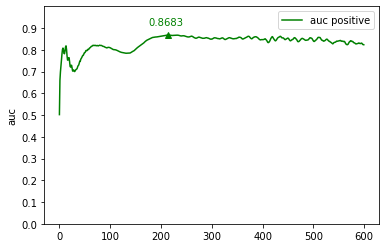

In [25]:
def draw_line(plt, epoch_list, data_list, color, label, max_marker=None):
    plt.plot(epoch_list, data_list, color=color, label=label)
    if max_marker is not None:
        max_index = np.argmax(data_list)
        val_str = "{:.4f}".format(data_list[max_index])
        plt.plot(epoch_list[max_index],data_list[max_index], color=color, marker=max_marker)
        plt.annotate(val_str,xytext=(-20, 10), textcoords='offset points',
            xy=(epoch_list[max_index],data_list[max_index]), color=color)

import matplotlib.pyplot as plt
draw_line(plt, epoch_list, auc_pos_list, 'g', label="auc positive", max_marker="^")
# draw_line(plt, epoch_list, auc_neg_list, 'b', label="auc negative", max_marker="^")
# draw_line(plt, epoch_list, auc_score_list, 'r', label="auc negative - positive", max_marker="^")


plt.ylabel('auc')
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, step=0.1))
plt.savefig("aggdv2.png", dpi=400)

In [26]:
print(max(auc_pos_list))

0.8683398488402397


ValueError: min() arg is an empty sequence